In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import ast
from itertools import chain
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt
pd.set_option('display.max_columns', None)
tf.random.set_seed(50)
np.random.seed(50)

### Code to prepare one_hot_df

In [2]:
TARGET_CLASS = "CHM2210"
df = pd.read_csv("data/full_set.csv")

# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)

# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df['Target_Semester']]

# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = ['Target_Points', 'Target_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df['Target_Grade'].isin(['WE', 'IF', 'W', 'WC'])]


final_df = final_df[final_df['Semester'] < final_df['Target_Semester']]

groupped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    'Target_Grade': 'first',
    'Target_Points': 'first',
}).reset_index()

all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

groupped_df['One_Hot_Classes'] = groupped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])

### code for models (change non max count)

In [3]:
train, testing_data = train_test_split(one_hot_df, test_size=0.2, random_state=50)
dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)

train_set = one_hot_df[one_hot_df.index.isin(train.index)]
dev_set = one_hot_df[one_hot_df.index.isin(dev.index)]
test_set = one_hot_df[one_hot_df.index.isin(test.index)]
columns_to_remove = []
for column in train_set.columns:
    value_counts = train_set[column].value_counts()
    max_count = value_counts.max()
    non_max_count = value_counts.sum() - max_count
    
    if non_max_count <= 20:
        columns_to_remove.append(column)
        
train_set = train_set.drop(columns=columns_to_remove)
dev_set = dev_set.drop(columns=columns_to_remove)
test_set = test_set.drop(columns=columns_to_remove)

print(train_set.shape, dev_set.shape, test_set.shape)

(9424, 355) (1178, 355) (1179, 355)


In [4]:
# Create pass/fail column
def map_pass_fail(grade):
    fail_grades = ['F', 'IF', 'W', 'D-', 'F', 'D+', 'D#', 'D+', 'F#', 'D', 'D', 'D-', 'U', 'W', 'F*', 'D*', 'CF', 'I', 'FF', 'Z', 'W*', 'F+', 'F-', 'F#', 'F*', 'D-*', 'IF', 'IF*', 'D+*', 'CIF', 'Z*', 'IU', 'M', 'CI', 'MU', 'U*', 'ID', 'IB', 'IU*', 'IS', 'CW']
    return 0 if grade in fail_grades else 1  # 0 = fail, 1 = pass

#Add columns fro grouped_df
groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(train_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered = groupped_df_filtered.set_index('Pidm')
train_set = train_set.join(groupped_df_filtered[add_columns], )

groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(dev_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
dev_set = dev_set.join(groupped_df_filtered[add_columns], )

groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(test_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
test_set = test_set.join(groupped_df_filtered[add_columns], )

# Apply the function to create pass/fail column
train_set['pass_fail'] = train_set['Target_Grade'].apply(map_pass_fail)
dev_set['pass_fail'] = dev_set['Target_Grade'].apply(map_pass_fail)
test_set['pass_fail'] = test_set['Target_Grade'].apply(map_pass_fail)

# # Drop irrelevant columns
X = train_set.drop(columns=['Target_Grade', 'pass_fail'])
X_dev = dev_set.drop(columns=['Target_Grade', 'pass_fail'])
X_test = test_set.drop(columns=['Target_Grade', 'pass_fail'])

# Drop rows with missing values
X = X.dropna()
X_dev = X_dev.dropna()
X_test = X_test.dropna()

# Extract the target variable (pass/fail)
y = train_set.loc[X.index, 'pass_fail']
y_dev = dev_set.loc[X_dev.index, 'pass_fail']
y_test = test_set.loc[test_set.index, 'pass_fail']

### undersampling logic(use if needed)

In [5]:
counts = train_set['pass_fail'].value_counts()
sample_count = min(counts.get(0, 0), counts.get(1, 1))

pass_class = X[y == 1]
fail_class = X[y == 0]

pass_sample = resample(pass_class, replace=False, n_samples=sample_count, random_state=50)
fail_sample = resample(fail_class, replace=False, n_samples=sample_count, random_state=50)

# Combine the undersampled data
X_undersampled = pd.concat([pass_sample, fail_sample])
y_undersampled = pd.concat([y[pass_sample.index], y[fail_sample.index]])

X_train = X_undersampled
y_train = y_undersampled

### Done preprocessing, init model

In [6]:
input_shape = X_train.shape[1]

checkpoint = ModelCheckpoint(
    f"MLP_model_for_{TARGET_CLASS}.h5", 
    monitor='accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_shape,)),  # Input layer
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_dev, y_dev),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint]
)



Epoch 1/50
45/71 [==================>...........] - ETA: 0s - loss: 4.1859 - accuracy: 0.5285  
Epoch 1: accuracy improved from -inf to 0.54412, saving model to MLP_model_for_CHM2210.h5
71/71 [==============================] - 1s 8ms/step - loss: 2.9682 - accuracy: 0.5441 - val_loss: 0.6728 - val_accuracy: 0.6316
Epoch 2/50
46/71 [==================>...........] - ETA: 0s - loss: 0.7320 - accuracy: 0.6046
Epoch 2: accuracy improved from 0.54412 to 0.60428, saving model to MLP_model_for_CHM2210.h5
71/71 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.6043 - val_loss: 0.6032 - val_accuracy: 0.6757
Epoch 3/50
58/71 [=======================>......] - ETA: 0s - loss: 0.7379 - accuracy: 0.5997
Epoch 3: accuracy did not improve from 0.60428
71/71 [==============================] - 0s 3ms/step - loss: 0.7185 - accuracy: 0.6038 - val_loss: 0.4380 - val_accuracy: 0.8031
Epoch 4/50
42/71 [================>.............] - ETA: 0s - loss: 0.8331 - accuracy: 0.5885
Epoch

37/37 [==============================] - 0s 803us/step
              precision    recall  f1-score   support

     Class 0       0.18      0.55      0.27       137
     Class 1       0.92      0.68      0.78      1042

    accuracy                           0.66      1179
   macro avg       0.55      0.61      0.53      1179
weighted avg       0.83      0.66      0.72      1179



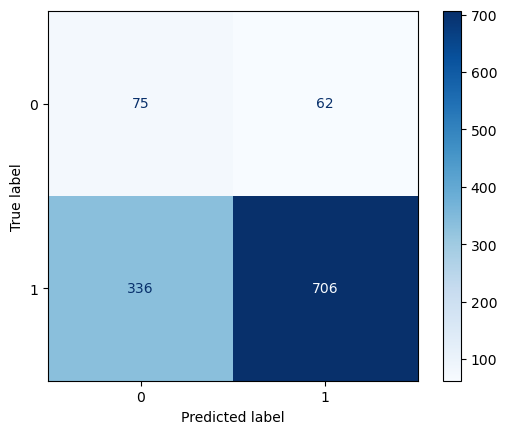

In [8]:
model = load_model(f"MLP_model_for_{TARGET_CLASS}.h5")
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)

y_pred_probs = model.predict(X_test)
# Convert probabilities to binary outputs (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))
conf_matrix = confusion_matrix(y_test, y_pred)

# Optionally, you can use a visual representation (if running in a notebook environment)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues')

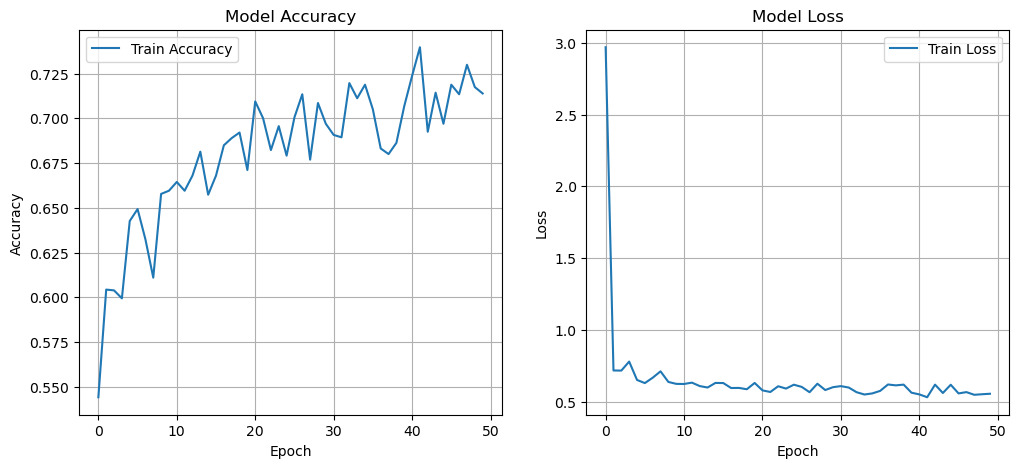

In [13]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()